# Notebook structure

1) First brute approach, developed before the session on Oct-15th.
2) Best practices applied from the session + improved version. Applied proper set splitting, baseline, features + parameters.

# 1. First approach

## Import libraries and read data

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [3]:
path = '/home/dan1dr/data/feature_frame.csv'
data = pd.read_csv(path)

## Understanding the problem

Develop a ML model that. given a user and product, predicts if the user would purchase it at that moment. Here will explore and select the model we will apply to the PoC. This model will be used to target users and send them a push notification. Relevant info:

- Current push notificiations have an open rate of 5%.
- Focus only on purchases of at least 5 items (shipping cost).
- Use only linear models to speed up the development.
- The result should allow Sales team to select an item from a list and segment the users for triggering that notification.
- Target: expected increase on monthly sales by 2% and uplift of 25% on selected items.

## Filtering and data preparation

In [10]:
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [11]:
num_items_ordered = data.groupby('order_id')['outcome'].sum()
filter = num_items_ordered[num_items_ordered >= 5].index

filtered_data = data[data['order_id'].isin(filter)]

print(f"Length initial data: {len(data)}")
print(f"Length filtered data: {len(filtered_data)}\n")

print(f"Unique orders initially: {data['order_id'].nunique()}")
print(f"Unique orders >= 5 items: {filtered_data['order_id'].nunique()}")

Length initial data: 2880549
Length filtered data: 2163953

Unique orders initially: 3446
Unique orders >= 5 items: 2603


In [5]:
print(num_items_ordered[num_items_ordered > 5].mean())
print(num_items_ordered[num_items_ordered > 5].median())

12.527332511302918
11.0


## Feature Engineering

According with previous assignments, we will select only the features that we think are more relevant for our prediction. Will make a few adjustments here and will be iterating along the notebook.

We will create a logistic regression model for the model. From there, we know this model may sensitive to feature scale (keep in mind potential feature scaling if model is poor). Additionaly, for feature selection, we will need to select relevant features to simplify it. The multicollinearity might play an important role, so we will be discarding highly correlated features. To sum up, we might need to create new feature that groups others.

The non-numeric cols will need to be enconded, so we could try applying one-hot encoding.

1. First, we will try to do some manual feature engineering.
2. Later, we will apply Lasso to force some coefficients to be zero and compare to our manual approach
3. Additionally, we might apply Ridge to see also the coefficients obtained (less extreme selection).

## 1) Manual

In [6]:
pd.set_option('display.max_columns', None)
filtered_data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [7]:
# We will remeber the classification we did in previous notebook:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

From numerical: 
- We will remove count_adults, count_children, count_pets and keep only count_adults, which seems to be highly representative. We will maintain count_babies as correlation it is not that high (0.15) and may provide info.
- We will remove std_days_to_buy_product_type and keep avg_days_to_buy_product_type (highly correlated between themselves. We may do it reversely also)
- We will remove std_days_to_buy_variant_id and keep avg_days_to_buy_variant_id (same thing)

From categorical:
- We will remove vendor and keep product_type (the former has too different values). Later we will apply one-hot encoding

From binary: 
- We would try to use some resampling technique for grouping the 4 into just 1. We will create a column 'any_event' to input value '1' if any of the four cols has a value of 1. In this sense, we address the unbalanced distribution (a bit), we simplify it and also keep the info if any of these events occured


In [8]:
# Remove numericals
numerical_remove = ['count_adults', 'count_children', 'count_babies',
                    'std_days_to_buy_product_type', 'std_days_to_buy_variant_id']
numerical = [col for col in numerical if col not in numerical_remove]

# Remove categoricals
categorical.remove('vendor')

# Create the binary one
filtered_data['any_event'] = filtered_data[['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].any(axis=1).astype(int)
binary = ['any_event']
# I'm thinking if maybe would be interesting to perform a sume here. If any_event = 2 would be stronger than 1 and so, while also keeping info about events.


/tmp/ipykernel_481/1254836267.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['any_event'] = filtered_data[['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']].any(axis=1).astype(int)


Additionally, let's check if order_date is always equal to created_at (maybe some orders are created but not ordered until X days). If so, let's remove order_date (created_at is has also hour and minut info). Maybe hourly data would be crucial for planning the timing of sending notifications.

In [9]:
if len(filtered_data[filtered_data['order_date'] == filtered_data['created_at']]) == len(filtered_data):
    print("ofc")

In [10]:
information.remove('order_date')
information

['variant_id', 'order_id', 'user_id', 'created_at']

In [11]:
cols = information + numerical + categorical + binary + predicted
final_data = filtered_data[cols]

Time format encoding for created_at. Later we could inspect if this granularity it is too much and it is better to leave it at day_of_week info

In [12]:
#Verify created at has pandas date_format
final_data['created_at'] = pd.to_datetime(final_data['created_at'])

# Extract year, month, day, and hour as separate features
final_data['year'] = final_data['created_at'].dt.year
final_data['month'] = final_data['created_at'].dt.month
# Extract the day of the week (numerical, 1-7, starting with Monday as 1)
final_data['day_of_week'] = final_data['created_at'].dt.dayofweek + 1
final_data['hour'] = final_data['created_at'].dt.hour
final_data = final_data.drop(columns=['created_at'])

/tmp/ipykernel_481/1071411211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['created_at'] = pd.to_datetime(final_data['created_at'])
/tmp/ipykernel_481/1071411211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['year'] = final_data['created_at'].dt.year
/tmp/ipykernel_481/1071411211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

One-hot encoding for product_type

In [14]:
# Apply one-hot encoding for 'vendor'
# Drop_first = True to get rid of an additional col. Binaries for keeping consistency as any_event
final_data = pd.get_dummies(final_data, columns=['product_type'], prefix='product', drop_first=True).astype(int)

print(final_data.shape)
final_data.head()

(2163953, 80)


,variant_id,order_id,user_id,user_order_seq,normalised_price,discount_pct,global_popularity,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,any_event,outcome,year,month,day_of_week,hour,product_allpurposecleaner,product_babyfood12months,product_babyfood6months,product_babymilkformula,product_babytoiletries,product_bathroomlimescalecleaner,product_bathshowergel,product_beer,product_binbags,product_bodyskincare,product_catfood,product_cereal,product_cleaningaccessories,product_coffee,product_condimentsdressings,product_cookingingredientsoils,product_cookingsaucesmarinades,product_delicatesstainremover,product_dental,product_deodorant,product_dishwasherdetergent,product_dogfood,product_driedfruitsnutsseeds,product_dryingironing,product_fabricconditionerfreshener,product_facialskincare,product_feedingweaning,product_femininecare,product_floorcleanerpolish,product_foodstorage,product_haircare,product_handsoapsanitisers,product_healthcarevitamins,product_homebaking,product_householdsundries,product_jamhoneyspreads,product_juicesquash,product_kidsdental,product_kidssnacks,product_kitchenovencleaner,product_kitchenrolltissues,product_longlifemilksubstitutes,product_maternity,product_nappies,product_nappypants,product_petcare,product_pickledfoodolives,product_premixedcocktails,product_ricepastapulses,product_shavinggrooming,product_snacksconfectionery,product_softdrinksmixers,product_superfoodssupplements,product_tea,product_tinspackagedfoods,product_toiletroll,product_washingcapsules,product_washingliquidgel,product_washingpowder,product_windowglasscleaner,product_wipescottonwool
0,33826472919172,2807985930372,3482464092292,3,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,33826472919172,2808027644036,3466586718340,2,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,33826472919172,2808099078276,3481384026244,4,0,0,0,0,2,33,42,30,30,0,0,2020,10,1,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,33826472919172,2808393957508,3291363377284,2,0,0,0,0,2,33,42,30,30,0,0,2020,10,2,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,33826472919172,2808434524292,3479090790532,3,0,0,0,0,2,33,42,30,30,0,0,2020,10,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Train model

Dataset seems to be big enough (2M rows), so we will split the data by i) 80% training set/ 10 validation/ 10 test; later ii) 70/15/15. Note that train_test_split applies a random selection (seed predefined for obtaining same values later on) with no replacement.

In [14]:
# Import model and split method
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Features and target variable
X = final_data.drop(columns='outcome')
y = final_data['outcome']

# Split the data and then split validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# We will do the same every time but will test it only against validation set

In [15]:
# Initialize model
model = LogisticRegression()

# Train
model.fit(X_train, y_train)

/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Validate the model
y_val_pred = model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


print("Confusion Matrix:")
print("Watch out: Rows are actual values (N and P), cols are predicted (N and P)")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:


/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    213182
           1       0.00      0.00      0.00      3213

    accuracy                           0.99    216395
   macro avg       0.49      0.50      0.50    216395
weighted avg       0.97      0.99      0.98    216395

Confusion Matrix:
Watch out: Rows are actual values (N and P), cols are predicted (N and P)
[[213182      0]
 [  3213      0]]


/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model does not converge with the default number of iterations = 100. Model didn't classified anything as positive! If we try to plot the curves, we will appreciate the classifier it is not a better option than flipping a coin and estimating.

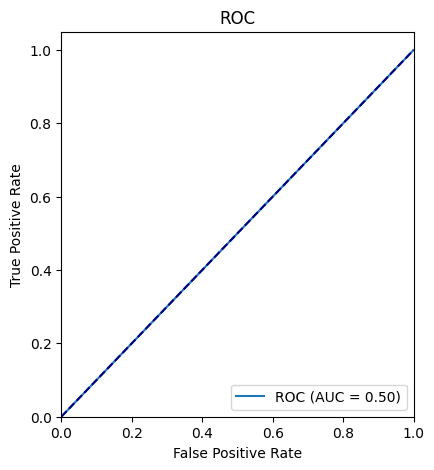

In [20]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


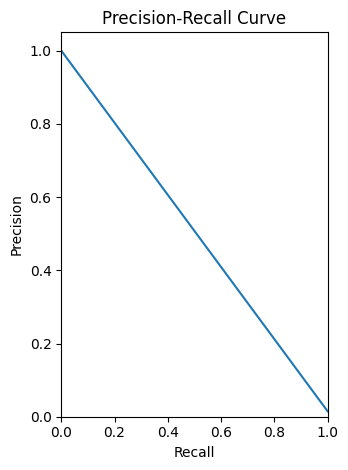

In [21]:
# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

We will use the feature scaling provided by scikit in order to standardized the features and enable the estimator to learn from them easier. This will substract the mean from the feature and divide by the std.

In [22]:
from sklearn.preprocessing import StandardScaler

X = final_data.drop(columns='outcome')
y = final_data['outcome']

# Feature scaler and apply to X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Initialize model
model = LogisticRegression()

# Train
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Validate the model
y_val_pred = model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:


/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    213182
           1       0.00      0.00      0.00      3213

    accuracy                           0.99    216395
   macro avg       0.49      0.50      0.50    216395
weighted avg       0.97      0.99      0.98    216395

Confusion Matrix:
[[213182      0]
 [  3213      0]]


/home/dan1dr/.cache/pypoetry/virtualenvs/zrive-ds-UEx3J_CK-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


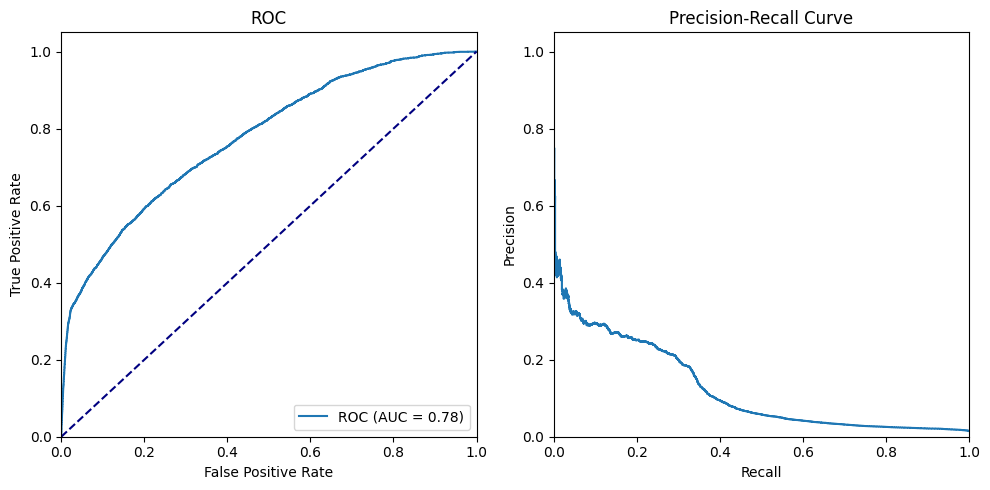

In [24]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

We see the model it is very good for predicting the negative (no-purchase), but poor for positive (purchases). This may come from the strongly unbalanced classes we had in the dataset.

In [78]:
final_data['outcome'].value_counts()

outcome
0    2132624
1      31329
Name: count, dtype: int64

In [79]:
final_data['any_event'].value_counts()

any_event
0    2104207
1      59746
Name: count, dtype: int64

First, let's usee the weight_class that scikit offers. Then we could think of oversampling the minority class, or undersampling the majority. We have 2M rows, so undersampling might be a good idea since we might have enough data for doing that. Oversampling may disrupt the data and add new ones, but may work also

In [25]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Initialize model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')

# Train
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [26]:
# Validate the model
y_val_pred = model.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    213182
           1       0.04      0.61      0.08      3213

    accuracy                           0.78    216395
   macro avg       0.52      0.70      0.48    216395
weighted avg       0.98      0.78      0.86    216395

Confusion Matrix:
[[166533  46649]
 [  1244   1969]]


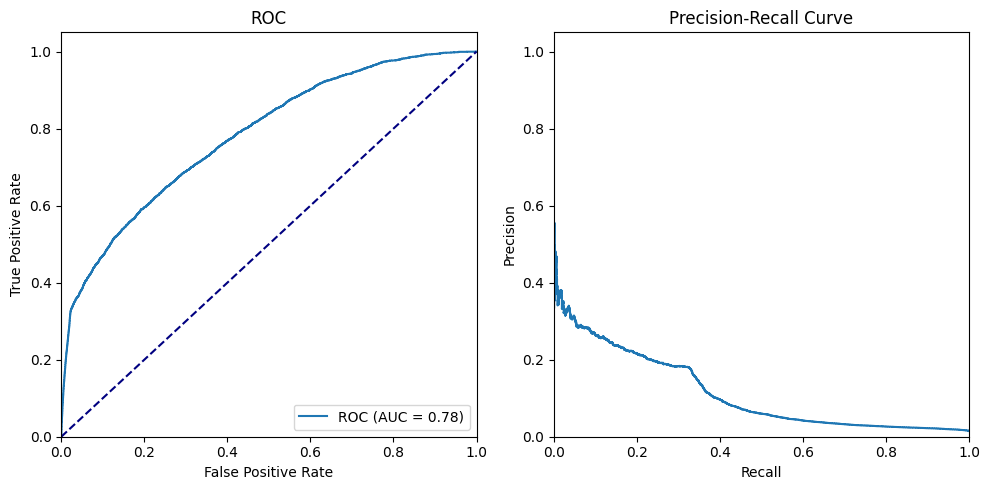

In [27]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

Better results with this approach, where we lose precision but gain sensitivity for purchases.

Let's also try luck using UnderSampler from under_sampling library AFTER the split data, for avoiding information leakage (another method for undersampling data)

In [28]:
from imblearn.under_sampling import RandomUnderSampler

X = final_data.drop(columns='outcome')
y = final_data['outcome']

# Feature scaler and apply to X data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Fit and apply the transform to the training data
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Train your model on the undersampled training data
model.fit(X_train, y_train)

# Predict the outcomes for the validation data
y_val_pred = model.predict(X_val)

# Print the classification report for validation results
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    213182
           1       0.04      0.61      0.08      3213

    accuracy                           0.78    216395
   macro avg       0.52      0.70      0.48    216395
weighted avg       0.98      0.78      0.86    216395

Confusion Matrix:
[[167349  45833]
 [  1251   1962]]


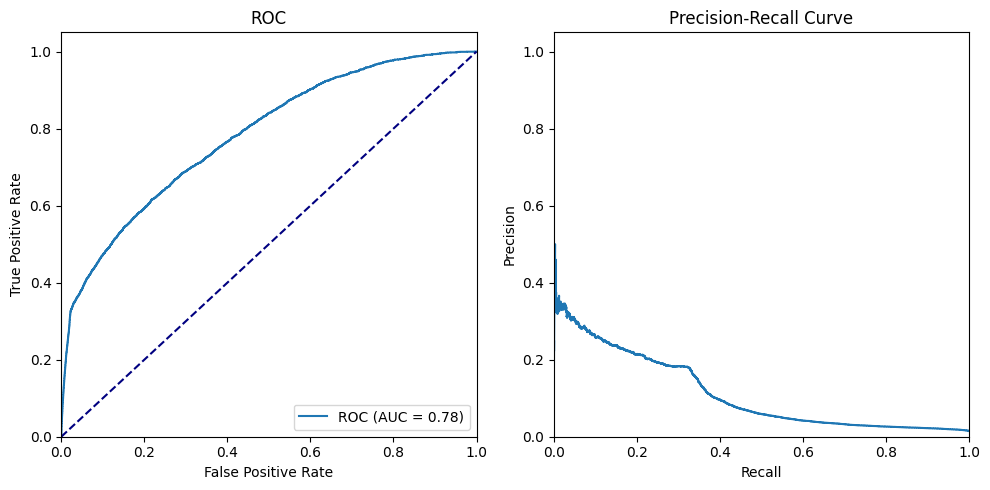

In [29]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

We obtain basically very similar results, so for the shake of simplicity, we will stay with the weight class that scikit provides. Curiously, both results obtain similar curves vs with no balance class for logistic regression. It may be due to the fact that, given the class 1 is so umbalanced, we do not appreciate high differences. However, we can see that in the precision in purchases (60% vs 4%, normal regression accuracy for positive is better) and recall in purchases (0% vs 62%, simple logistic regression does not find any purchase, while the later models do).

Now, with these results, let's pause for a moment and analyze the numbers obtained:

- Precision (True positive / true positive + false positive). Measures the accuracy of positive predictions. If the model predicts a purchase won't happen, it is correct almost always. If it predicts it will happen, only is correct 4% of the time (generating lots of false positives). Remember that current push open rate is around 5%, so it is feasible to be slightly below that. Would be useful to have the purchase rate per opened notification.

- Recall or true positive rate (True positive / true positive + false negative). Measures the ability to identify all positives. If model predicts no purchase, it identifies 77% of the time. If the model predicts a purchase, it identifies 63% of the purchases

- ROC Curve. Knowing that classes are strongly unbalanced, we can appreciate a few things: We start to generate false alarms very quickly, as provided by precision before. When 50% of the alarms are false (FPR at 0.5), we are identifying 80% of the positive alarms. Then the number of false alarms grow very quickly (so basically we will be spamming the user)

- Precision-recall curve. Precision decreases very fast for almost no recall (loss of accuracy of positive predictions when trying to gain sensivity).

We want to have a recall enough to appreciate purchases, and with a reasonable amount of false positives but fixed for avoiding churn rates (which Sales team mentioned it had a huge cost). Since we would like to target those users that are likely to buy those products, we can expect to increase the probability threshold and capture secure notifications. We will be missing positives, but sending those that we are more sure they will be buying.

We see a light peak on the precision-recall curve where recall is around = 0.32, we might try to get the probability threshold from there and try to see how our model performs with that parameter:



In [30]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recall = 0.32
closest_recall_idx = np.argmin(np.abs(recall - desired_recall))

# Get the threshold corresponding to that index
threshold_at_desired_recall = thresholds[closest_recall_idx]
print(f"Threshold for Recall = {desired_recall}: {threshold_at_desired_recall}")

Threshold for Recall = 0.32: 0.8416240756662322


In [31]:
custom_threshold = 0.84

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_val_custom_threshold = (y_val_probs > custom_threshold).astype(int)


print("Classification Report:")
print(classification_report(y_val, y_val_custom_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_custom_threshold))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    213182
           1       0.18      0.32      0.23      3213

    accuracy                           0.97    216395
   macro avg       0.59      0.65      0.61    216395
weighted avg       0.98      0.97      0.97    216395

Confusion Matrix:
[[208529   4653]
 [  2180   1033]]


We see we misscalculated 2k positive values as negative (false negative), and we generated 4k false positives. However, we were right for 1k purchases realised. The precision for purchase was 18%, which compared to our current open rate, seems OK.

In [32]:
custom_threshold = 0.7

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_val_custom_threshold = (y_val_probs > custom_threshold).astype(int)


print("Classification Report:")
print(classification_report(y_val, y_val_custom_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_custom_threshold))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    213182
           1       0.14      0.35      0.20      3213

    accuracy                           0.96    216395
   macro avg       0.57      0.66      0.59    216395
weighted avg       0.98      0.96      0.97    216395

Confusion Matrix:
[[206260   6922]
 [  2084   1129]]


Now there is the trade-off betweem how many we want to capture and generate as false positive vs the total we are able to dismiss, so the max number for false negatives. As per the problem's statement, we would like to avoid false positives as they might churn – hence lower precision for positives but also lower recall. In this sense, we might select P = 0.84 instead of 0.7

If we want to know what were the weights assigned in my model:

In [20]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Initialize model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')

# Train
model.fit(X_train, y_train)

# Access the coefficients (weights) of the features
X = final_data.drop(columns='outcome')
coefficients = model.coef_[0]

# Create a DataFrame to associate coefficients with feature names
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient values (for better visualization)
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the coefficients
coefficients_df.head(10)

,Feature,Coefficient
14,year,-0.672157
12,avg_days_to_buy_product_type,-0.607223
15,month,-0.525724
13,any_event,0.516628
61,product_nappies,-0.393418
4,normalised_price,-0.297199
23,product_bathroomlimescalecleaner,0.285365
38,product_dishwasherdetergent,0.263845
21,product_babymilkformula,-0.262905
72,product_tinspackagedfoods,0.249028


In [21]:
coefficients_df.tail(10)

,Feature,Coefficient
2,user_id,-0.017418
7,count_pets,0.016740
44,product_feedingweaning,-0.014295
19,product_babyfood12months,0.009898
8,people_ex_baby,-0.009382
1,order_id,0.008983
16,day_of_week,0.006718
70,product_superfoodssupplements,-0.002507
67,product_shavinggrooming,-0.000317
6,global_popularity,0.000000


There a lots of values almost not used for the prediction, so let's try to use Lasso to penalize them and make another predicitons

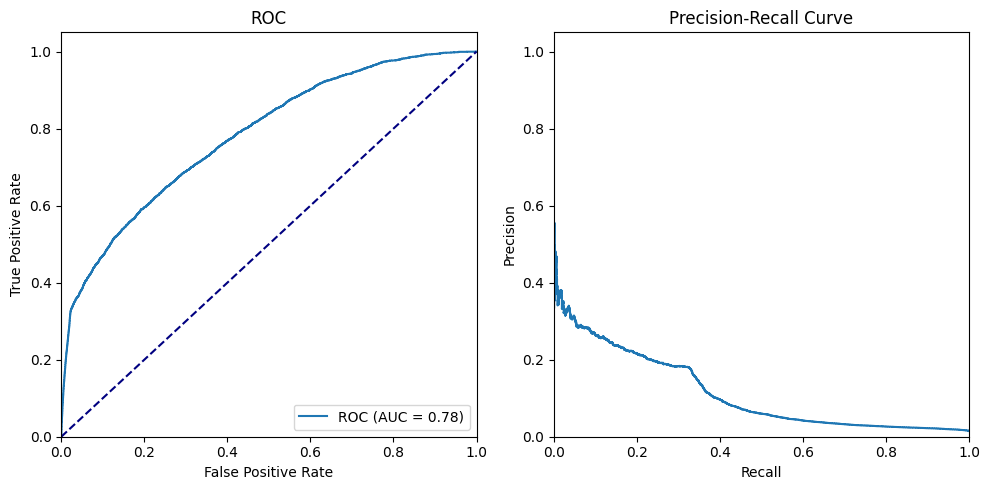

In [22]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## 2) Lasso

In [43]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Add L1 penalty and choose an allowed solver
model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

# Train
model.fit(X_train, y_train)

# Predict the outcomes for the validation data
y_val_pred = model.predict(X_val)

In [51]:
X = final_data.drop(columns='outcome')

# Print the classification report for validation results
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

coefficients = model.coef_[0]  # Coefficients for the first (and only) class
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
coefficients_df.head(10)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    213182
           1       0.04      0.61      0.08      3213

    accuracy                           0.78    216395
   macro avg       0.52      0.70      0.48    216395
weighted avg       0.98      0.78      0.86    216395

Confusion Matrix:
[[166535  46647]
 [  1244   1969]]


,Feature,Coefficient
12,avg_days_to_buy_product_type,-0.772772
14,year,-0.671969
15,month,-0.525529
13,any_event,0.516638
61,product_nappies,-0.477559
21,product_babymilkformula,-0.320373
60,product_maternity,-0.291124
4,normalised_price,-0.270189
23,product_bathroomlimescalecleaner,0.245388
56,product_kidssnacks,-0.242586


In [53]:
coefficients_df.tail(20)

,Feature,Coefficient
5,discount_pct,0.042723
69,product_softdrinksmixers,0.035872
9,days_since_purchase_variant_id,-0.034336
54,product_juicesquash,-0.027826
27,product_bodyskincare,0.027113
31,product_coffee,0.026051
63,product_petcare,0.024966
44,product_feedingweaning,-0.023822
17,hour,0.020988
67,product_shavinggrooming,-0.020007


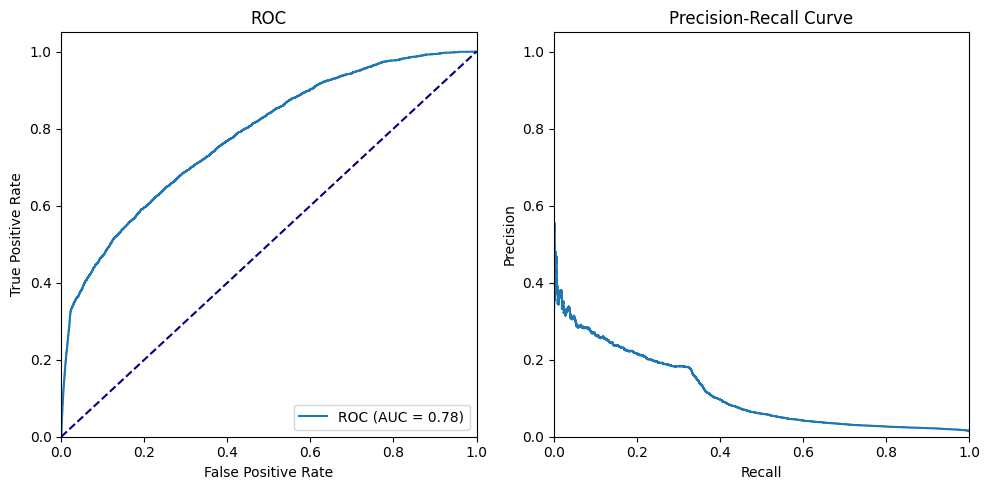

In [57]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [55]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recall = 0.35
closest_recall_idx = np.argmin(np.abs(recall - desired_recall))

# Get the threshold corresponding to that index
threshold_at_desired_recall = thresholds[closest_recall_idx]
print(f"Threshold for Recall = {desired_recall}: {threshold_at_desired_recall}")

Threshold for Recall = 0.35: 0.6916317393298211


In [56]:
custom_threshold = 0.69

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_val_custom_threshold = (y_val_probs > custom_threshold).astype(int)


print("Classification Report:")
print(classification_report(y_val, y_val_custom_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_custom_threshold))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    213182
           1       0.14      0.35      0.20      3213

    accuracy                           0.96    216395
   macro avg       0.56      0.66      0.59    216395
weighted avg       0.98      0.96      0.97    216395

Confusion Matrix:
[[206210   6972]
 [  2083   1130]]


Pretty much same results as before. Lasso took 2h to run & didn't reduced any additonal coeff to 0, obtaining very similar results. This might mean that there is not any irrelevant features among the selected.

Let's try then to play with alpha parameter for stronger regularizations. If alpha increses, then the regularization is stronger. This parameter is adjusted by the C parameter in scikit, which is the inverse of alpha (i.e. higher alpha == lower C)

In [30]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

model1 = LogisticRegression(C=0.5, class_weight='balanced')
model2 = LogisticRegression(C=0.1, class_weight='balanced')
model3 = LogisticRegression(C=0.01, class_weight='balanced')

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

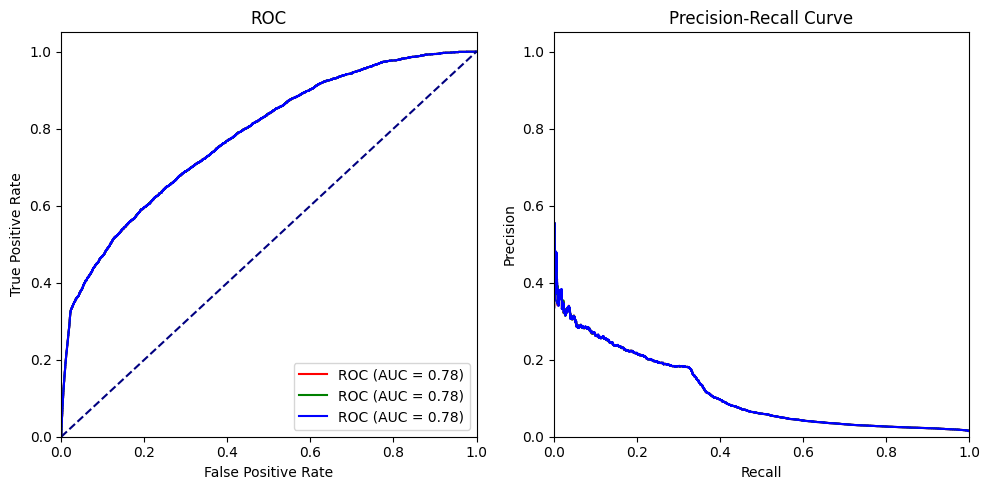

In [28]:
# Models with different values of C
models = [model1, model2, model3]
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 5))

# For each model, calculate and plot ROC and Precision-Recall curves
for i, model in enumerate(models):
    # Calculate probabilities for the positive class
    y_val_probs = model.predict_proba(X_val)[:, 1]

    # ROC Curve
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

    plt.subplot(1, 2, 1)
    plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})', color=colors[i])

    # Precision-Recall Curve
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

    plt.subplot(1, 2, 2)
    plt.plot(recall_val, precision_val, color=colors[i])

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In [29]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

# Models with different values of C
models = [model1, model2, model3]

for i, model in enumerate(models):
    # Predict the outcomes for the validation data
    y_val_pred = model.predict(X_val)

    # Print the classification report for validation results
    print(f"Classification Report for Model {i + 1}:")
    print(classification_report(y_val, y_val_pred))

    print(f"Confusion Matrix for Model {i + 1}:")
    cm = confusion_matrix(y_val, y_val_pred)
    print(cm)

    # Extract feature coefficients
    coefficients = model.coef_[0]  # Coefficients for the first (and only) class
    coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

    # Sort coefficients by absolute value
    coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

    print(f"Top 10 Features for Model {i + 1}:")
    print(coefficients_df.head(10))


Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    213182
           1       0.04      0.61      0.08      3213

    accuracy                           0.78    216395
   macro avg       0.52      0.70      0.48    216395
weighted avg       0.98      0.78      0.86    216395

Confusion Matrix for Model 1:
[[166533  46649]
 [  1244   1969]]
Top 10 Features for Model 1:
                             Feature  Coefficient
14                              year    -0.671855
12      avg_days_to_buy_product_type    -0.606313
15                             month    -0.525428
13                         any_event     0.516626
61                   product_nappies    -0.393317
4                   normalised_price    -0.296625
23  product_bathroomlimescalecleaner     0.285124
38       product_dishwasherdetergent     0.263621
21           product_babymilkformula    -0.262714
72         product_tinspackagedfoods     0.2

Almost same results for different C parameters in l2 regularization.

In [31]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

model = LogisticRegression(C=0.001, class_weight='balanced')

model.fit(X_train, y_train)

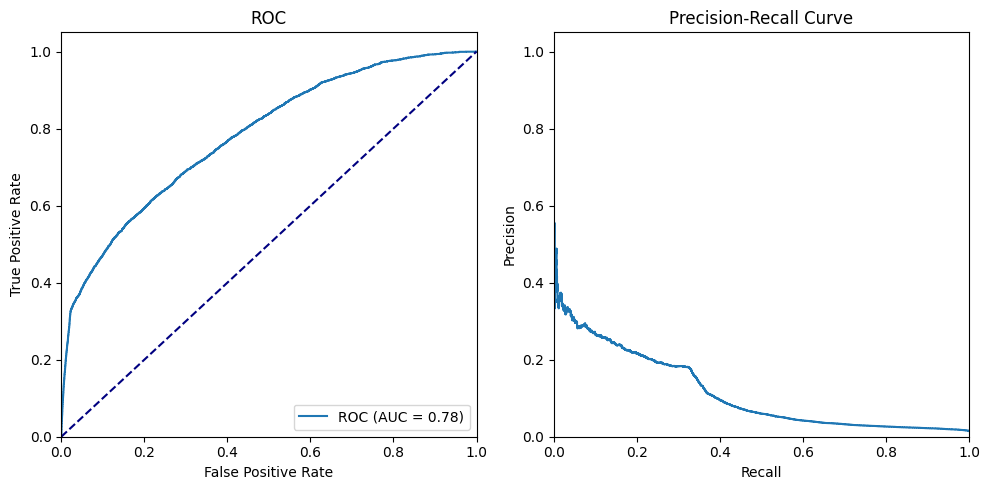

In [32]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

In [34]:
X = final_data.drop(columns='outcome')
y_val_pred = model.predict(X_val)

# Print the classification report for validation results
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

coefficients = model.coef_[0]  # Coefficients for the first (and only) class
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
coefficients_df.tail(10)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.88    213182
           1       0.04      0.61      0.08      3213

    accuracy                           0.78    216395
   macro avg       0.52      0.70      0.48    216395
weighted avg       0.98      0.78      0.86    216395

Confusion Matrix:
[[167075  46107]
 [  1247   1966]]


,Feature,Coefficient
43,product_facialskincare,0.018726
54,product_juicesquash,0.016255
7,count_pets,0.015768
16,day_of_week,0.009763
8,people_ex_baby,-0.009313
19,product_babyfood12months,-0.003423
1,order_id,-0.002904
52,product_householdsundries,-0.002543
45,product_femininecare,-0.001950
6,global_popularity,0.000000


## Reiterate on feature selection

Based on the best model we achieved, which is using Logistic Regression with l2 and class_weight balanced, we will take at the final weights used (most and least) and do another round of feature selection

In [36]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Initialize model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')

# Train
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)

In [37]:
X = final_data.drop(columns='outcome')
coefficients = model.coef_[0]  # Coefficients for the first (and only) class
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
coefficients_df.head(10)

,Feature,Coefficient
14,year,-0.672157
12,avg_days_to_buy_product_type,-0.607223
15,month,-0.525724
13,any_event,0.516628
61,product_nappies,-0.393418
4,normalised_price,-0.297199
23,product_bathroomlimescalecleaner,0.285365
38,product_dishwasherdetergent,0.263845
21,product_babymilkformula,-0.262905
72,product_tinspackagedfoods,0.249028


In [38]:
coefficients_df.tail(10)

,Feature,Coefficient
2,user_id,-0.017418
7,count_pets,0.016740
44,product_feedingweaning,-0.014295
19,product_babyfood12months,0.009898
8,people_ex_baby,-0.009382
1,order_id,0.008983
16,day_of_week,0.006718
70,product_superfoodssupplements,-0.002507
67,product_shavinggrooming,-0.000317
6,global_popularity,0.000000


- We see any event account for 0.5 in the model (remember we created this variable). We could undo it and introduce the full binary cols, as they seem very relevant
- We see even people_ex_baby was not used, despite we kept the most representative one. We could delete it
- We see day_of_week throwed no info, we could instead present day_of_month
- We see global_popularity was forced to 0, so we can delete it also

In [41]:
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

cols = information + numerical + categorical + binary + predicted
final_data = filtered_data[cols]

#Verify created at has pandas date_format
final_data['created_at'] = pd.to_datetime(final_data['created_at'])

# Extract year, month, day, and hour as separate features
final_data['year'] = final_data['created_at'].dt.year
final_data['month'] = final_data['created_at'].dt.month
# Extract the day of the week (numerical, 1-7, starting with Monday as 1)
final_data['day_of_month'] = final_data['created_at'].dt.day
final_data['hour'] = final_data['created_at'].dt.hour
final_data = final_data.drop(columns=['created_at'])

# Apply one-hot encoding for 'vendor'
# Drop_first = True to get rid of an additional col. Binaries for keeping consistency as any_event
final_data = pd.get_dummies(final_data, columns=['product_type'], prefix='product', drop_first=True).astype(int)

#Drop cols
final_data = final_data.drop(columns=['global_popularity', 'people_ex_baby'])

print(final_data.shape)
final_data.head()

/tmp/ipykernel_481/2320102903.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['created_at'] = pd.to_datetime(final_data['created_at'])
/tmp/ipykernel_481/2320102903.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['year'] = final_data['created_at'].dt.year
/tmp/ipykernel_481/2320102903.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

(2163953, 81)


,variant_id,order_id,user_id,user_order_seq,normalised_price,discount_pct,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,ordered_before,abandoned_before,active_snoozed,set_as_regular,outcome,year,month,day_of_month,hour,product_allpurposecleaner,product_babyfood12months,product_babyfood6months,product_babymilkformula,product_babytoiletries,product_bathroomlimescalecleaner,product_bathshowergel,product_beer,product_binbags,product_bodyskincare,product_catfood,product_cereal,product_cleaningaccessories,product_coffee,product_condimentsdressings,product_cookingingredientsoils,product_cookingsaucesmarinades,product_delicatesstainremover,product_dental,product_deodorant,product_dishwasherdetergent,product_dogfood,product_driedfruitsnutsseeds,product_dryingironing,product_fabricconditionerfreshener,product_facialskincare,product_feedingweaning,product_femininecare,product_floorcleanerpolish,product_foodstorage,product_haircare,product_handsoapsanitisers,product_healthcarevitamins,product_homebaking,product_householdsundries,product_jamhoneyspreads,product_juicesquash,product_kidsdental,product_kidssnacks,product_kitchenovencleaner,product_kitchenrolltissues,product_longlifemilksubstitutes,product_maternity,product_nappies,product_nappypants,product_petcare,product_pickledfoodolives,product_premixedcocktails,product_ricepastapulses,product_shavinggrooming,product_snacksconfectionery,product_softdrinksmixers,product_superfoodssupplements,product_tea,product_tinspackagedfoods,product_toiletroll,product_washingcapsules,product_washingliquidgel,product_washingpowder,product_windowglasscleaner,product_wipescottonwool
0,33826472919172,2807985930372,3482464092292,3,0,0,0,33,42,30,30,0,0,0,0,0,2020,10,5,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,33826472919172,2808027644036,3466586718340,2,0,0,0,33,42,30,30,0,0,0,0,0,2020,10,5,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,33826472919172,2808099078276,3481384026244,4,0,0,0,33,42,30,30,0,0,0,0,0,2020,10,5,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,33826472919172,2808393957508,3291363377284,2,0,0,0,33,42,30,30,0,0,0,0,0,2020,10,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,33826472919172,2808434524292,3479090790532,3,0,0,0,33,42,30,30,0,0,0,0,0,2020,10,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Train again the model

In [42]:
X = final_data.drop(columns='outcome')
y = final_data['outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

# Initialize model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')

# Train
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)

In [43]:
X = final_data.drop(columns='outcome')
y_val_pred = model.predict(X_val)

# Print the classification report for validation results
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

coefficients = model.coef_[0]  # Coefficients for the first (and only) class
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
coefficients_df.head(10)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    213182
           1       0.04      0.62      0.08      3213

    accuracy                           0.77    216395
   macro avg       0.52      0.70      0.47    216395
weighted avg       0.98      0.77      0.86    216395

Confusion Matrix:
[[165490  47692]
 [  1229   1984]]


,Feature,Coefficient
15,year,-0.747774
10,avg_days_to_buy_product_type,-0.607219
16,month,-0.593842
11,ordered_before,0.434268
62,product_nappies,-0.395642
24,product_bathroomlimescalecleaner,0.285216
22,product_babymilkformula,-0.270324
39,product_dishwasherdetergent,0.263882
73,product_tinspackagedfoods,0.249627
31,product_cleaningaccessories,0.235490


In [82]:
coefficients_df.tail(15)

,Feature,Coefficient
56,product_kidsdental,-0.035290
13,active_snoozed,0.035236
7,days_since_purchase_variant_id,-0.034834
53,product_householdsundries,0.024792
28,product_bodyskincare,0.024669
55,product_juicesquash,0.022988
18,hour,0.020846
45,product_feedingweaning,-0.013937
6,count_pets,0.012153
1,order_id,0.011454


Model behaviour it's pretty similar for P = 0.5 in the confusion matrix. Let's try to plot the curves, specially the precision-recall again

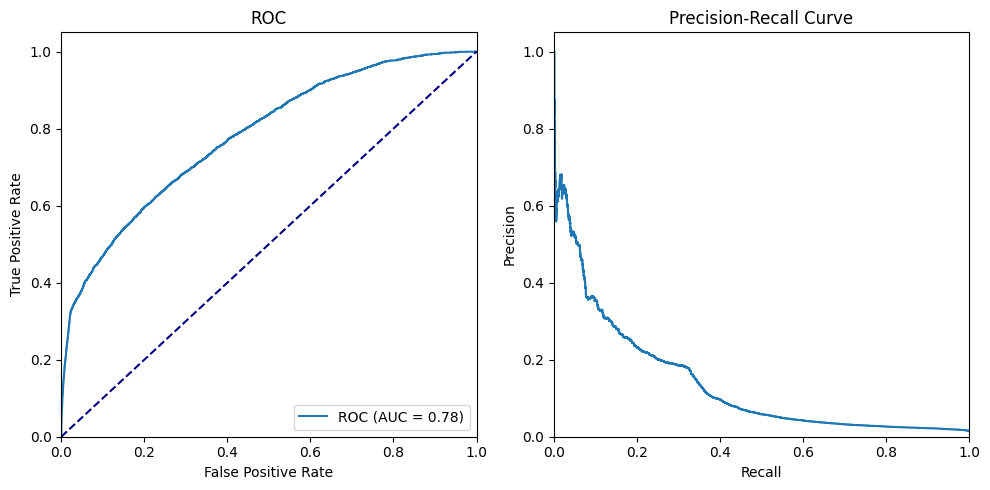

In [45]:
# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]

# ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)  # Calculate AUC

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")


# Precision-Recall Curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)

plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

ROC is similar but we see a different pattern in the precision vs recall behaviour. Let's explote them using different threshold for maximising precison while we get a sufficient recall to appreciate positive values. We see that for same recall as we selected before (0.32 approx) we obtain similar or even worse results. However, if we select a little fewer recall, we obtain significant increases in precision vs previous model. Let's use 0.3, 0.2, and 0.15.

In [46]:
recall

In [ ]:
[5.15846135e-05 6.75884443e-05 7.46107959e-05 ... 9.99949782e-01
 9.99958761e-01 9.99979388e-01]

In [49]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recalls = [0.3, 0.2, 0.15]
thresholds_at_desired_recalls = {}

for i in desired_recalls:
    closest_recall_idx = np.argmin(np.abs(recall - i))
    
    # Get the threshold corresponding to that index
    threshold_at_desired_recall = thresholds[closest_recall_idx]
    
    thresholds_at_desired_recalls[i] = threshold_at_desired_recall

for recall_value, threshold_value in thresholds_at_desired_recalls.items():
    print(f"Threshold for Recall = {recall_value}: {threshold_value}")


Threshold for Recall = 0.3: 0.8495145097324593
Threshold for Recall = 0.2: 0.9326935056189675
Threshold for Recall = 0.15: 0.9510581366637918


In [62]:
thresholds_at_desired_recalls.items

<function dict.items>

In [66]:
y_val_probs = model.predict_proba(X_val)[:, 1]

for recall, threshold in thresholds_at_desired_recalls.items():
    # Calculate probabilities for the positive class
    y_val_custom_threshold = (y_val_probs > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_custom_threshold))

    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_custom_threshold),"\n")

Threshold: 0.8495145097324593
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    213182
           1       0.19      0.30      0.23      3213

    accuracy                           0.97    216395
   macro avg       0.59      0.64      0.61    216395
weighted avg       0.98      0.97      0.97    216395

Confusion Matrix:
[[208946   4236]
 [  2249    964]] 

Threshold: 0.9326935056189675
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    213182
           1       0.23      0.20      0.21      3213

    accuracy                           0.98    216395
   macro avg       0.61      0.60      0.60    216395
weighted avg       0.98      0.98      0.98    216395

Confusion Matrix:
[[211054   2128]
 [  2570    643]] 

Threshold: 0.9510581366637918
Classification Report:
              precision    recall  f1-score   support

           0       0.9

Good behaviour for adjusting the precision of positives, but we are losing slightly more positives that we're not catching. This model seems to work better with lower recall. Let's try to validate 0.22, 0.19 and 0.17.

In [78]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recalls = [0.25, 0.22, 0.19]
thresholds_at_desired_recalls = {}

for i in desired_recalls:
    closest_recall_idx = np.argmin(np.abs(recall - i))
    
    # Get the threshold corresponding to that index
    threshold_at_desired_recall = thresholds[closest_recall_idx]
    
    thresholds_at_desired_recalls[i] = threshold_at_desired_recall

for recall_value, threshold_value in thresholds_at_desired_recalls.items():
    print(f"Threshold for Recall = {recall_value}: {threshold_value}")


Threshold for Recall = 0.25: 0.9080735787919318
Threshold for Recall = 0.22: 0.9249901789056006
Threshold for Recall = 0.19: 0.937330083213395


In [79]:
y_val_probs = model.predict_proba(X_val)[:, 1]

for recall, threshold in thresholds_at_desired_recalls.items():
    # Calculate probabilities for the positive class
    y_val_custom_threshold = (y_val_probs > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_custom_threshold))

    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_custom_threshold),"\n")

Threshold: 0.9080735787919318
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    213182
           1       0.20      0.25      0.22      3213

    accuracy                           0.97    216395
   macro avg       0.59      0.62      0.60    216395
weighted avg       0.98      0.97      0.98    216395

Confusion Matrix:
[[209995   3187]
 [  2410    803]] 

Threshold: 0.9249901789056006
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    213182
           1       0.22      0.22      0.22      3213

    accuracy                           0.98    216395
   macro avg       0.60      0.60      0.60    216395
weighted avg       0.98      0.98      0.98    216395

Confusion Matrix:
[[210672   2510]
 [  2506    707]] 

Threshold: 0.937330083213395
Classification Report:
              precision    recall  f1-score   support

           0       0.99

FP / TP is better. A 1/4 of the alerts sent will be bought. So it we would like to opt for a more conservative model, this might be the choice. Additionally, if we want to be really sure about the predictions for positives, we can set the recall to 0.1:

In [80]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recalls = [0.1]
thresholds_at_desired_recalls = {}

for i in desired_recalls:
    closest_recall_idx = np.argmin(np.abs(recall - i))
    
    # Get the threshold corresponding to that index
    threshold_at_desired_recall = thresholds[closest_recall_idx]
    
    thresholds_at_desired_recalls[i] = threshold_at_desired_recall

for recall_value, threshold_value in thresholds_at_desired_recalls.items():
    print(f"Threshold for Recall = {recall_value}: {threshold_value}")


Threshold for Recall = 0.1: 0.9726607989659661


In [81]:
y_val_probs = model.predict_proba(X_val)[:, 1]

for recall, threshold in thresholds_at_desired_recalls.items():
    # Calculate probabilities for the positive class
    y_val_custom_threshold = (y_val_probs > threshold).astype(int)
    print(f"Threshold: {threshold}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_custom_threshold))

    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_custom_threshold),"\n")

Threshold: 0.9726607989659661
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    213182
           1       0.35      0.10      0.16      3213

    accuracy                           0.98    216395
   macro avg       0.67      0.55      0.57    216395
weighted avg       0.98      0.98      0.98    216395

Confusion Matrix:
[[212597    585]
 [  2892    321]] 



## Assesing models vs. target impact

The targeted impact for the problem was to increase monthly sales by 2% and a boost of 25% over selected items. Let's do a few hypothesis and then some quick numbers:

- We assume monthly volume as the mean for the last 3 months provided in the data, so JFM 21. We get that number very generalistic from previous module, roughly let's say it was £20k per month. So we expect an increase of £200/m
- If we expect a boost of 25% over selected items, let's say that we will be adding +25% units for all the items that we selected for a notification.

If we assume that the avg value for all the items can be estimated dividing the monthly value (20k) by the total ordered items by month from that period (~4000), we get it is around £5. So we will need to send a total of 200/5 = 40 items bought exclusively because of the push notifications. 

From there, we can opt for the more conservative model as we will be meeting completely the expectations and doublechecking with very high confident, that we do not spam the user too much. If we apply these number for the last model we try with recall = 0.19:

In [145]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

desired_recall = 0.19
closest_recall_idx = np.argmin(np.abs(recall - desired_recall))

# Get the threshold corresponding to that index
threshold_at_desired_recall = thresholds[closest_recall_idx]
print(f"Threshold for Recall = {desired_recall}: {threshold_at_desired_recall}")

Threshold for Recall = 0.19: 0.937330083213395


In [147]:
custom_threshold = 0.937

# Calculate probabilities for the positive class
y_val_probs = model.predict_proba(X_val)[:, 1]
y_val_custom_threshold = (y_val_probs > custom_threshold).astype(int)


print("Classification Report:")
print(classification_report(y_val, y_val_custom_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_custom_threshold))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    213182
           1       0.24      0.19      0.21      3213

    accuracy                           0.98    216395
   macro avg       0.62      0.59      0.60    216395
weighted avg       0.98      0.98      0.98    216395

Confusion Matrix:
[[211278   1904]
 [  2600    613]]


In [150]:
filtered_data['variant_id'].nunique()

913

We will be sending twice a month: e.g. 2.5k push notification, generating 600 items bought for sure. From there, we can say our open rate will be 25% at very minimun, with a more realistic approach about 30-50% (assuming a conversion rate per notification opened ~50%).

Now let's penalize that the items that we're predicting will be bought whether the notifications are sent or not, by a factor of 50% less impact of the notifications.

So from the example, we will be sending 5k notifications/month with a total impact estimated of 600 items extra sold, resulting in £3k (+15% uplift). The products selected for the promo we can assume will be mainly new promos/discounts, so the target will be more than surprased by this increase.


# 2. Second and improved approach

Previous version was a brute and very forced model, trying with too many features since the beginning and no baseline defined. Here we will take the lessons learned and apply the following:

1. Define the minimun features as a first approach and then, if needed, add more.
2. Proper train/validation split taking into account the temporality of data and avoiding information leakage.
3. Defining a baseline as a our worst estimator for comparing the model
4. Play with different parameters dynamically when training models
5. Final decision

## 1) Features

In [12]:
filtered_data.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [13]:
# Initial classification:

predicted = ['outcome']
information = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
numerical = ['user_order_seq', 'normalised_price', 'discount_pct', 'global_popularity',
            'count_adults', 'count_children', 'count_babies', 'count_pets', 
            'people_ex_baby', 'days_since_purchase_variant_id', 
            'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
            'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type']

categorical = ['product_type', 'vendor']
binary = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']

In [34]:
cols = information + binary

## 2) Train/validation/test set

Makes sense to apply temporal splitting since: i) it is an increasing temporal series ii) we might incur in information leakage if we split several orders across train/test. We could make the point that the feature created_at would incorporate that info into the prediction, but it is also true that the data has changed too much since beginning that it is not justified no just incorporate that variable as a separate one and continue with random samples.

There could be different ways of applyinh this (sliding window validation if we want to test in different points in time or a walk-forward validation splitting). In this case, let's select a simple walk-forward with first 4 months for training, 2 weeks after for validation and 2 last weeks for testing.

/tmp/ipykernel_478/705284945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['order_date'] = pd.to_datetime(filtered_data['order_date']).dt.date


<Axes: xlabel='order_date'>

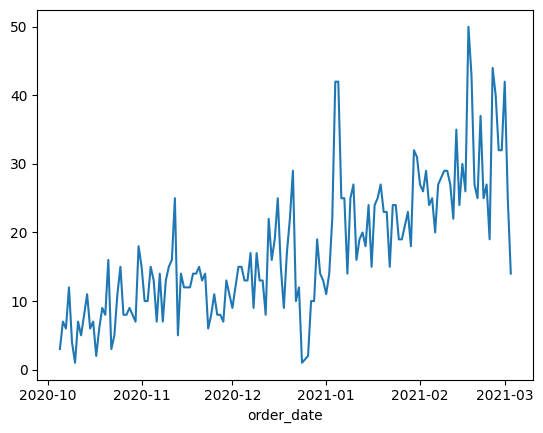

In [70]:
filtered_data['order_date'] = pd.to_datetime(filtered_data['order_date']).dt.date
daily_orders = filtered_data.groupby('order_date').order_id.nunique()
sns.lineplot(x=daily_orders.index, y=daily_orders.values)

In [71]:
print(daily_orders.index.max())
print(daily_orders.index.min())

2021-03-03
2020-10-05


In [110]:
num_days = len(daily_orders)

test_days = 14
validation_days = 14
train_days = num_days - test_days - validation_days

# Train
train_start = daily_orders.index.min()
train_end = train_start + timedelta(days = train_days)

# Validation
validation_end = train_end + timedelta(days = validation_days)

# Test
test_end = daily_orders.index.max()

In [111]:
train = filtered_data[filtered_data.order_date <= train_end]
validation = filtered_data[(filtered_data.order_date > train_end) & (filtered_data.order_date <= validation_end)]
test = filtered_data[filtered_data.order_date > validation_end]

print(f"Train set: {len(train) / len(filtered_data):.2f}")
print(f"Train set: {len(validation) / len(filtered_data):.2f}")
print(f"Train set: {len(test) / len(filtered_data):.2f}")

Train set: 0.65
Train set: 0.16
Train set: 0.19


In [112]:
# Let's give a lit bit extra days for train
test_days = 10
validation_days = 10
train_days = num_days - test_days - validation_days

# Train
train_start = daily_orders.index.min()
train_end = train_start + timedelta(days = train_days)

validation_end = train_end + timedelta(days = validation_days)

test_end = daily_orders.index.max()

train = filtered_data[filtered_data.order_date <= train_end]
validation = filtered_data[(filtered_data.order_date > train_end) & (filtered_data.order_date <= validation_end)]
test = filtered_data[filtered_data.order_date > validation_end]

print(f"Train set: {len(train) / len(filtered_data):.2f}")
print(f"Train set: {len(validation) / len(filtered_data):.2f}")
print(f"Train set: {len(test) / len(filtered_data):.2f}")


Train set: 0.73
Train set: 0.13
Train set: 0.13


## 3) Baseline